In [65]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import math

In [66]:
local_image = "sample_pie.png"

In [67]:
img = Image.open(local_image).convert("RGB")
img = np.array(img)
size = img.shape
# encoded_string = base64.b64encode(img)

In [68]:
# re_img = np.fromstring(encoded_string)
# re_img = np.resize(re_img, size)
# re_img.shape

In [69]:
import requests
import json

In [70]:
# url = 'http://49.50.175.108:6010/items/'
url = 'http://localhost:8000/items/'
req = {
    "instances" : img.tolist() # [H, W, C]
}

response = requests.post(
    url=url,
    data=json.dumps(req)
)

In [71]:
res_eval = eval(response.text)
res_eval

{'im_shape': [209, 417, 3],
 'dgr': [284.13968507075475, 75.86031492924523],
 'grp': [[[202.39407348632812, 115.20999145507812],
   [126.49090576171875, 95.67401885986328],
   [202.7940216064453, 37.22562789916992],
   0.7475329041481018],
  [[202.39407348632812, 115.20999145507812],
   [202.7940216064453, 37.22562789916992],
   [126.49090576171875, 95.67401885986328],
   0.7475329041481018]]}

In [101]:
# backend server
url = 'http://localhost:8001/'
print(
    requests.get(url=url).text
)

req = {
    "image_as_list" : img.tolist() # [H, W, C]
}

response = requests.post(
    url=url + "backend/",
    data=json.dumps(req)
)
response

{"main":"page"}


<Response [200]>

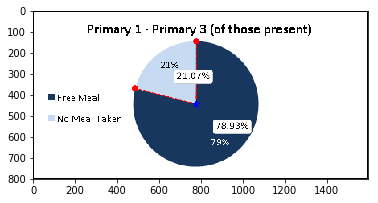

In [102]:
resp_dict = eval(response.text)
image_arr = np.array(resp_dict["im_plot"])
plt.imshow(image_arr)

In [11]:
def get_distance(x1, y1, x2, y2):
    return ((((x2 - x1 )**2) + ((y2-y1)**2) )**0.5)

def get_arc_center(points):
    x_center, y_center, x_left, y_left, x_right, y_right = points
    assert abs(get_distance(x_left,y_left, x_center, y_center) - get_distance(x_right, y_right, x_center, y_center)) < 5

    radius = get_distance(x_left,y_left, x_center, y_center)
    norm_x_left, norm_x_right = (x_left - x_center)/radius, (x_right - x_center)/radius

    # y가 역방향임
    norm_y_left, norm_y_right = (y_center - y_left)/radius, (y_center - y_right)/radius

    angle = math.atan2((norm_y_left + norm_y_right)/2, (norm_x_left + norm_x_right)/2)
    coord = (math.cos(angle)*radius + x_center, -math.sin(angle)*radius + y_center)

    return list(map(int, coord))

ccw_x, ccw_y :::  202.7940216064453 37.22562789916992
ccw_x, ccw_y :::  126.49090576171875 95.67401885986328


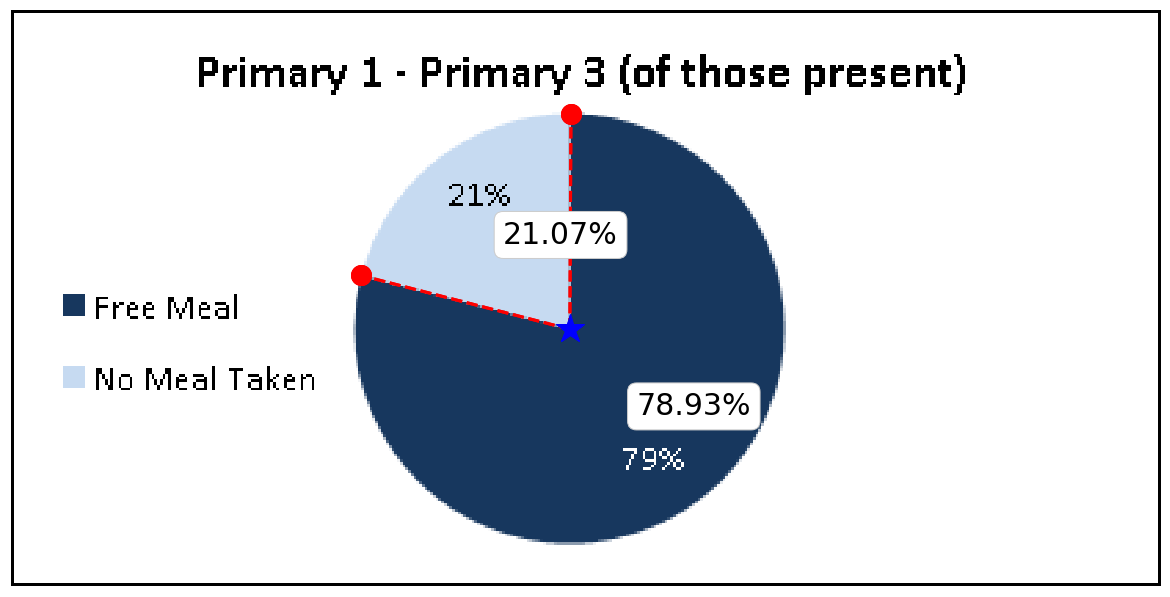

In [25]:
MODEL_URL = 'http://localhost:8000/items/'


image_list = img.tolist() #image_as_list
image_arr = np.array(image_list, dtype=np.uint8)
# send to model server
req_dict = {
    "instances" : image_list # [H, W, C]
}
response = requests.post(
    url=MODEL_URL,
    data=json.dumps(req_dict)
)

# parse a response
resp_eval = eval(response.text)

H, W, _ = resp_eval["im_shape"]
degree_list = resp_eval["dgr"]
group_list = resp_eval["grp"]

k = 8
figsize = (1, H / W) if H >= W else (W / H, 1)
figsize = (k * figsize[0], k * figsize[1])
fig = plt.figure(figsize=figsize)
plt.imshow(image_arr)

for degree, group in zip(degree_list, group_list):
    
    center_x, center_y = group[0]
    ccw_x, ccw_y = group[2]
    print("ccw_x, ccw_y ::: ", ccw_x, ccw_y)
    cw_x, cw_y = group[1]
    
    plt.plot([center_x, ccw_x], [center_y, ccw_y], '--r', linewidth=3)
    plt.plot([center_x, cw_x], [center_y, cw_y], '--r', linewidth=3)
    
    plt.plot(center_x, center_y, '*b', markersize=30)
    plt.plot(ccw_x, ccw_y, '.r', markersize=40)
    plt.plot(cw_x, cw_y, '.r', markersize=40)

    arc_center = get_arc_center(
        [center_x, center_y, ccw_x, ccw_y, cw_x, cw_y]
    )
    text_x = (arc_center[0] + center_x)/2
    text_y = (arc_center[1] + center_y)/2

    bbox_config = {
        'boxstyle': 'round',
        'ec': (0.8, 0.8, 0.8),
        'fc': (1.0, 1.0, 1.0)
    }
    text_str = f"{float(degree)/360*100:.2f}%"
    if degree < 180:
        plt.text(
            text_x, text_y, 
            text_str, fontsize=30,
            bbox = bbox_config
        )
    else:
        text_x = 2 * center_x - text_x
        text_y = 2 * center_y - text_y
        plt.text(
            text_x, text_y, 
            text_str, fontsize=30,
            bbox = bbox_config
        )

plt.axis('off')
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.subplots_adjust(
    left = 0, bottom = 0, right = 1, top = 1,
    hspace = 0, wspace = 0
)

fig.canvas.draw()
image_bunary = fig.canvas.renderer._renderer
image_arr = np.array(image_bunary)

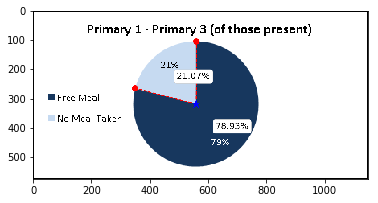

In [26]:
plt.imshow(image_arr)